# **Travel Salesman Problem (TSP)**

Vamos a resolver nuestro problema de viajero usando la formulación nativa del problema pero añadiendo las condiciones particulares de nuestro problema. Las condiciones particulares de nuestro problema vienen dadas por los siguientes puntos:

- El inicio de la ruta y el final debe ser el nodo 0
- La segunda ciudad que vamos a visitar (sin contar el origen) debe ser la ciudad 2

**Teoría del TSP**

Vamos a introducir la formulación nativa del problema TSP, en esta formulacion el numero de variables es de $N^{3}$, siendo $N$ el número de ciudades o nodos de nuestro mapa o grafo. Esta formulación no es la mas optima para ser implementada en una QPU, debido a que otras formulaciones requieren de un menor uso de variables, pero si nos permite adquirir una comprensión facil y sencilla del problema TSP. En esta formulación tenemos variables del tipo $x_{u,v,t}$, donde x es una variable binaria que toma los valores {0,1}. El significado de esta variables es muy sencillo, si $x_{u,v,t} = 1$ implica que el camino o arista $(u,v)$ ha sido recorrido en el tiempo $t$, de lo contrario, si posee valor nulo, significa que no pertenece a nuestro recorrido global. La razón de que las variables $(u,v)$ tengan mas indices que nodos hay, es por que el nodo de partida debe ser duplicado, es decir el nodo inicial y final son el mismo aunque se denotan de forma distinta. En la formulación nativa los indices toman los siguientes valores, $u,v \in [0,...,N+1]$ y $t \in [0,...,N]$. La función objetivo viene dada por la siguiente expresión:

$$\sum_{u=0}^{N+1} \sum_{v=0}^{N+1} \sum_{t=0}^{N} x_{u,v,t} d_{u,v}$$

Donde la magnitud $d_{u,v}$ representa la distancia entre los nodos $(u,v)$. Por otro lado la función objetivo es completada por una serie de restricciones, las generales del problema TSP y las particulares de nuestro problema.

Restricciones generales:

- Solo debe salir de cada ciudad una vez:

 $$\forall u \in [0,...,N] ---> \sum_{v=1}^{N+1} \sum_{t=0}^{N} x_{u,v,t} = 1$$

- Hay que llegar a cada ciudad una vez:

 $$\forall v \in [1,...,N+1] ---> \sum_{u=0}^{N} \sum_{t=0}^{N} x_{u,v,t} = 1$$

- Solo pueden existir soluciones con cliclos conexos cerrados:

$$\forall t \in [0,...,N-1], u,v \in [0,...,N] ---> x_{u,v,t}(1 - \sum_{w=1}^{N+1} x_{v,w,t+1}) = 0$$

Sobre estas restricciones debemos añadir las restricciones especificas de nuestro problema. Restricciones particulares:

- Partimos inicialmente del nodo 0:

$$\sum_{v=1}^{N} x_{0,v,0} = 1$$

- La ciudad final de llegada es la 5 (es la misma que la 0):

$$\sum_{u=1}^{N} x_{u,5,4} = 1$$

- La tercera ciudad en ser visitada es la 2 (en t=2), sin contar la ciudad de partida:

$$\sum_{u=1}^{N} x_{u,2,2} = 1$$


**Librerias**

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from neal import SimulatedAnnealingSampler
from qubovert import boolean_var

from dwave.system import LeapHybridSampler

import dwave.inspector
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite

**Grafo del problema TSP**

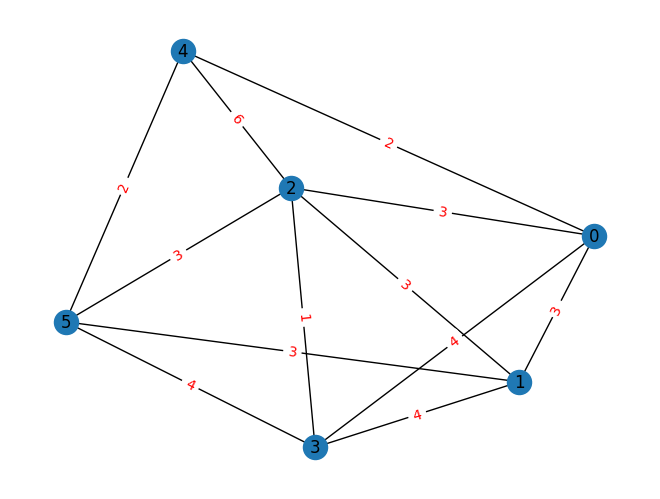

In [12]:
# Creamos el grafo

G = nx.Graph()

# Añadimos las conexiones entre nodos y sus pesos que nos indica el valor de sus aristas
# Los caminos deben ser bidireccionales

G.add_edge(0,1, weight = 3)
G.add_edge(1,0, weight = 3)
G.add_edge(0,2, weight = 3)
G.add_edge(2,0, weight = 3)
G.add_edge(0,3, weight = 4)
G.add_edge(3,0, weight = 4)
G.add_edge(0,4, weight = 2)
G.add_edge(4,0, weight = 2)
G.add_edge(1,2, weight = 3)
G.add_edge(2,1, weight = 3)
G.add_edge(1,3, weight = 4)
G.add_edge(3,1, weight = 4)
G.add_edge(2,3, weight = 1)
G.add_edge(3,2, weight = 1)
G.add_edge(2,4, weight = 6)
G.add_edge(4,2, weight = 6)

# Añadimos el nodo 5 que representa nuestro nodo 0 pero en el paso final, en este caso no es necesario crear un camino bidireccional

new_node = 5

G.add_node(new_node)

for neighbor in G.neighbors(0):
    G.add_edge(neighbor, new_node, weight=G[0][neighbor]['weight'])

# Dibujar el grafo

pos = nx.spring_layout(G)
nx.draw(G, pos)

# Obtener los pesos de las aristas y crear un diccionario

edge_labels = nx.get_edge_attributes(G, 'weight')

# Dibujar las etiquetas de las aristas

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Obtener los nombres de los nodos y crear un diccionario

node_labels = {node: str(node) for node in G.nodes()}

# Dibujar las etiquetas de los nodos

nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black')

# Mostrar el grafo

plt.show()

In [28]:
# Obtenemos el numero de ciudades

N = G.number_of_nodes()

# Creamos todas las variables binarias de nuestro problema TSP para un tamañano dado por N
# Necesitamos dos vairables para representar la ciudad final, el nodo 0 = 5
# Al incorporar el nodo 5 en realidad ya hemos añadido las N+1 variables de nuestro problema

x = {}
n_ciudades = N 
tiempo_max = N - 1

# Guardamos una lista de 3-tuplas en el que almacenamos solo los trios de indices (u, v, t) que permite la topologia del grafo

permitted_variables = []

for u in range(n_ciudades):
    for v in range(n_ciudades):
        for t in range(tiempo_max):
            if G.has_edge(u, v):
               permitted_variables.append((u, v, t))

# Creamos una lista de copia para poder eliminar las 3-tuplas que no aparecen debido a las C.C y las C.I de nuestro problema

permitted_variables_final = permitted_variables

# Creamos las variables binarias que estan permitidas por el grafo 

for u, v, t in permitted_variables:
    x[(u, v, t)] = boolean_var('x{}_{}_{}'.format(u, v, t))

# Eliminamos las vairables binarias las cuales sabemos que no pueden pertenecer a nuestra solución final debido a las C.I y C.C de nuestro
# Problema particular

# Partimos inicialmente de la ciudad 0, esta restricción se puede implementar como la negación del complementario
# Ninguna ciudad distinta de x[(0,v,0)] puede ser visitada

for u, v, t in permitted_variables:
    if u != 0 and t==0:
       x[(u, v, t)] = 0
       permitted_variables_final.remove((u, v, t))
    
# Dado que se parte inicialmente de la ciudad 0 en t=0, podemos eliminar el resto de variabes x([0,v,t]) con t !=0

for u, v, t in permitted_variables:
    if u == 0 and t != 0:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))

# La tercera ciudad en ser visitada es la ciudad 2, esta restricción se implementa como la negación del complementario
# Ninguna ciudad distinta de la ciudad 2 puede ser visitada en t=2. 

for u, v, t in permitted_variables:
    if v != 2 and t==2:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))


# Dado que el camino es cerrado tenemos que imponer que la ultima ciudad visitada sea la ciudad inicial
# Por tanto tenemos que todas las variables distintas de x[(i,5,4)] son cero donde recordemos 
# Que el nodo 0 = 5 

for u, v, t in permitted_variables:
    if v != 5 and t==4:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))
            
# Dado que el nodo 5 es el nodo 0 y dado que ademas solo puede ser visitado en ultimo lugar
# Podemos eliminar todas las variables menos la de t=4

for u, v, t in permitted_variables:
    if v==5 and t != 4: 
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))

# Dado que el nodo 5 es el nodo 0 y dado que ademas solo puede ser visitado en ultimo lugar
# Tampoco pueden salir del nodo 5

for u, v, t in permitted_variables:
    if u==5:
       x[(u, v, t)] = 0
       permitted_variables_final.remove((u, v, t))

# Construimos la función objetivo

model = sum(x[(u, v, t)]*G[u][v]['weight'] for u, v, t in permitted_variables_final)

# Fijamos el coeficiente de Lagrange

lamda = 400

# Añadimos las restricciones asociadas al problema TSP inlcuidas aquellas que son restricciones particulares de nuestro problema

# 1) Partimos inicialmente de la ciudad 0

model.add_constraint_eq_zero(sum([x[u,v,t] for u, v, t in permitted_variables_final if u==0 and t==0])-1, lam=lamda)

# 2) La ciudad final de llegada es la 5 (es la misma que la 0)

model.add_constraint_eq_zero(sum([x[u,v,t] for u, v, t in permitted_variables_final if v==5 and t==4])-1, lam=lamda) 

# 3) La segunda ciudad en ser visitada es la 2 (en t=2), sin contar la ciudad de partida 

model.add_constraint_eq_zero(sum([x[u,v,t] for u, v, t in permitted_variables_final if v==2 and t==2])-1, lam=lamda) 

# 4) Solo debe salir de cada ciudad una vez:

for u, v, t in permitted_variables_final:
    if u!=5:
       model.add_constraint_eq_zero(sum(x[(u, j, k)] for i, j, k in permitted_variables_final if i==u and j>=1) -1, lam=lamda )

# 5) Hay que llegar a cada ciudad una vez:
    
for u , v, t in permitted_variables_final:
    if v != 0:
       model.add_constraint_eq_zero(sum(x[(i, v, t)] for i, j, t in permitted_variables_final if j==v and i!=5) -1,lam=lamda)

# 6) Esta restricción garantiza que no se formen se formen ciclos inconexos como solución:

for u, v, t in permitted_variables_final:
    if t < 4 and u != 5 and v != 5:
        model.add_constraint_eq_zero(x[(u, v, t)]*(1 - sum(x[(v, w, k)] for i, w, k in permitted_variables_final if k==t+1 and v==i)),lam=lamda)


In [31]:
# Convertimos el modelo a QUBO 

qubo = model.to_qubo()
dwave_qubo = qubo.Q

# Usamos el simulador que permite D-Wave

#samplest = SimulatedAnnealingSampler().sample_qubo(dwave_qubo, num_reads=10000)

# Usamos el calculo hibrido clasico-QPU

samplest = LeapHybridSampler().sample_qubo(dwave_qubo)

# Usamos el calculo puramente cuantico QPU

#samplest = LazyFixedEmbeddingComposite(DWaveSampler()).sample_qubo(dwave_qubo,num_reads=1000)

qubo_solution = samplest.first.sample

model_solution = model.convert_solution(qubo_solution)
solution_valid = model.is_solution_valid(model_solution)

# Filtramos y obtenemos solo las soluciones que pertenecen a nuestra ruta

results = list(filter(lambda s: s[1]!=0,model_solution.items()))


print("Variables que pertenecen al resultado:",results)
print("Distancia total recorrida:", model.value(model_solution),'km')
print("Satiface restricciones:", solution_valid)


Variables que pertenecen al resultado: [('x0_1_0', 1), ('x1_3_1', 1), ('x2_4_3', 1), ('x3_2_2', 1), ('x4_5_4', 1)]
Distancia total recorrida: 16 km
Satiface restricciones: True


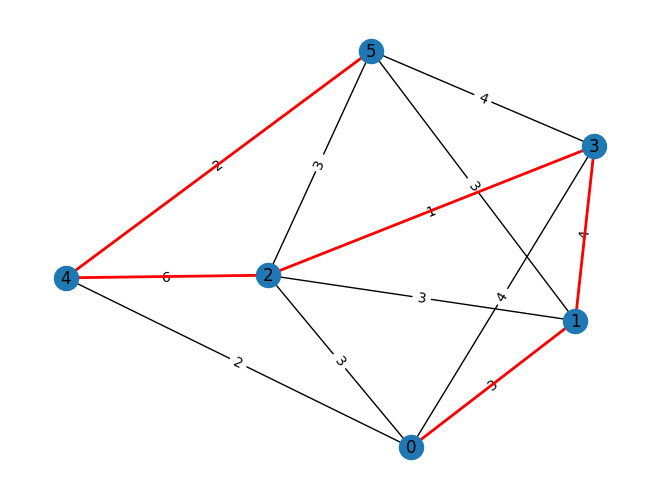

In [34]:
# Obtenemos los trios de indices de nuestra solución final para poder representar el camino final

tuplas = [(int(x[1]), int(x[3]), int(x[5])) for x, _ in results]
tuplas_ordenadas = sorted(tuplas, key=lambda x: x[2])

# Dibujar el grafo

pos = nx.spring_layout(G)
nx.draw(G, pos)

# Obtener los pesos de las aristas y crear un diccionario

edge_labels = nx.get_edge_attributes(G, 'weight')

# Dibujar las etiquetas de las aristas

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

# Obtener los nombres de los nodos y crear un diccionario

node_labels = {node: str(node) for node in G.nodes()}

# Dibujar las etiquetas de los nodos

nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black')

# Pintar las aristas de la solución en rojo

for u, v, t in tuplas_ordenadas:
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='red', width=2)

# Mostrar el grafo
plt.show()
